# Puntos geográficos y curvas de consumo
---
A lo largo de este notebook y utilizando unos datos de consumo dummy simulando que se trata de puntos de consumo de contadores alojados en ciudades de EEUU veremos como utilizando el paquete `folium` es posible su localización geográfica así como la adicción de gráficas sobre dichos puntos, como por ejemplo, el consumo mensual.

# Librerias
---

In [1]:
import pandas as pd
from datetime import datetime
import random

import folium
import vincent
import seaborn as sns
from folium.plugins import MarkerCluster, TimestampedGeoJson

# Lectura de datos
---
Disponemos de dos fuentes de datos:

1) `example_consumption.csv`: corresponde al consumo horario para distintos puntos de consumo. Las variables de análisis son las siguientes: 
* *point_id*: identificar del punto de medida
* *city*: ciudad de EEUU donde se aloja el contador 
* *state*: estado de EEUU donde se encuentra la ciudad 
* *latitude* y *longitude*: coordendas (x,y) del punto
* *timestamp*: momento horario de la medidad
* *value*: consumo
    
2) `example_clima.csv`: dataset que alberga información meteorológica de granularidad diaria para las distintas ciudades. En este caso, los atributos que tenemos son: *city*, *humidity*, *precipProbability*, *pressure*, *temperatureMax*, *temperatureMin*, *timestamp*, *visibility*, *windSpeed*.

In [19]:
dataset_clima = pd.read_csv('example_clima.csv', sep=",", index_col = 0)
dataset_points = pd.read_csv('example_comsumption.csv', sep=",", index_col = 0)

# Preprocesamiento de la información
---
## Unificación de ambos dataframes
---
Observamos diferencia en la granularidad de tiempo entre ambos datasets. Debemos agregar la información de consumo a nivel diario pues es la granularidad más grande que disponemos entre ambos datasets.

### Agrupación diaria para cada punto de análisis
---
Así pues, calcularemos el consumo total diario para cada punto de análisis.

In [21]:
dataset_points['date'] = dataset_points['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
dataset_points['date'] = dataset_points['date'].apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
dataset_points_daily = dataset_points.groupby(['point_id', 'city', 'state',
                                               'latitude', 'longitude', 'date'])['value'].sum()
dataset_points_daily = dataset_points_daily.reset_index(['point_id', 'city', 'state',
                                                         'latitude', 'longitude', 'date']).reset_index(drop=True)
dataset_points_daily.head()

,point_id,city,state,latitude,longitude,date,value
0,701330,Kotzebue,AK,66.897222,-162.583333,2013-01-01,33.839458
1,701330,Kotzebue,AK,66.897222,-162.583333,2013-01-02,38.141579
2,701330,Kotzebue,AK,66.897222,-162.583333,2013-01-03,38.110843
3,701330,Kotzebue,AK,66.897222,-162.583333,2013-01-04,38.880994
4,701330,Kotzebue,AK,66.897222,-162.583333,2013-01-05,38.280993


### Unificación de datasets por ciudad y tiempo de análisis
---
Además, para los siguientes estudios, nos quedaremos con la temperatura (en particular, `temperatureMax` y `temperatureMin`) como medida de influencia sobre el consumo.

In [23]:
dataset_clima = dataset_clima.rename(columns={'timestamp': 'date'})
dataset = dataset_points_daily.merge(dataset_clima, how='left', on=['city', 'date'])
dataset.index = pd.to_datetime(dataset['date'])
dataset = dataset[['city', 'state', 'latitude', 'longitude', 'value', 'temperatureMax', 'temperatureMin']]
dataset.head()

,city,state,latitude,longitude,value,temperatureMax,temperatureMin
date,,,,,,,
2013-01-01,Kotzebue,AK,66.897222,-162.583333,33.839458,-3.51,-7.39
2013-01-02,Kotzebue,AK,66.897222,-162.583333,38.141579,-0.54,-6.24
2013-01-03,Kotzebue,AK,66.897222,-162.583333,38.110843,-4.74,-9.37
2013-01-04,Kotzebue,AK,66.897222,-162.583333,38.880994,-2.61,-7.35
2013-01-05,Kotzebue,AK,66.897222,-162.583333,38.280993,-2.70,-12.43


# Localización en el mapa de EEUU. Agrupación de los puntos por cercanía
---
Localizaremos los puntos de análisis y se agruparán por cercanía según sus coordenadas usando la función `MakerCluster`.

In [26]:
dataset_coordinates = dataset[['city', 'latitude', 'longitude']].drop_duplicates()
coordinates = {}
for i in range(dataset_coordinates.shape[0]):
    coordinates[dataset_coordinates.iloc[i, 0]] = (dataset_coordinates.iloc[i,1], dataset_coordinates.iloc[i,2])

In [27]:
USA_coordinates = (45.0000000, -97.0000000)
m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")
m_cluster = MarkerCluster().add_to(m)
for c in coordinates:
    folium.Marker(location = coordinates[c], tooltip = c).add_to(m_cluster)
m

# Análisis por estado: Consumo medio de la electricidad consumida por estado (`Choropleth map`)
---
Utilizando los polígonos referidos a los estados del mapa, podemos conocer el consumo total en cada uno de los estados utilizando el consumo individualizado por los puntos pertenecientes a cada nivel superior (`state`).

In [29]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

dataset_state = dataset.groupby(['state'])['value'].sum()
dataset_state = dataset_state.reset_index('state').reset_index(drop=True)

USA_coordinates = (45.0000000, -97.0000000)
m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=dataset_state,
 columns=['state', 'value'],
 key_on='feature.id',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Consumo total de electricidad en cada uno de los estados'
)
folium.LayerControl().add_to(m)
m

# Evolución mensual de cada punto de medida
---
Utilizaremos el atributo `value` que marca el consumo eléctrico para cada punto de medida. Los datos correspondientes a los puntos de medida son de 1 año de análisis (2013 en particular). Calcularemos el consumo medio mensual para cada punto de medida para conocer así la evolución eléctrica mensual para cada punto de análisis.

## Agrupación mensual para cada punto de medida.
----
Para análisis posteriores calcularemos el consumo total mensual (`sum`). Sin embargo, para establecer una comparación gráfica, calcularemos el consumo medio mensual así como las temperaturas mínimas y máximas a lo largo del mes de análisis.

Si es cierto que no disponemos de datos de temperatura para todos los puntos de medida, en ese caso, únicamente visualizaremos la curva de consumo.

El paquete `folium` nos permite desplegar gráficas html en cada uno de los marcadores del mapa. Así podremos comparar las temperaturas mínimas y máximas con el consumo medio a lo largo de los 12 meses en cada punto de medida.

In [30]:
dataset['month'] = dataset.index.month

city_month_electricity = dataset.groupby(['city', 'month']).agg({'value': 'sum', 
                                                                 'temperatureMax': 'max', 
                                                                 'temperatureMin': 'min'})

city_month_electricity = city_month_electricity.reset_index(['city', 'month']).reset_index(drop=True)

city_month_electricity_graph = dataset.groupby(['city', 'month']).agg({'value': 'mean', 
                                                                 'temperatureMax': 'max', 
                                                                 'temperatureMin': 'min'})

city_month_electricity_graph = city_month_electricity_graph.reset_index(['city', 'month']).reset_index(drop=True)

m = folium.Map(location=USA_coordinates, zoom_start = 3, tiles = "OpenStreetMap")
for c in coordinates:
    city_month_electricity_c = city_month_electricity_graph[city_month_electricity_graph.city == c]
    if city_month_electricity_c.isna().sum().sum() == 0:
        df = city_month_electricity_c[['value', 'temperatureMax', 'temperatureMin']]
    else:
        df = city_month_electricity_c['value']
    
    df.index = ["2013/"+str(month) for month in city_month_electricity_c.month.tolist()]
    df.index = pd.to_datetime(df.index)
    scatter_chart = vincent.Line(df, width=600, height=300)
    scatter_chart.axis_titles(x='Month', y='Average electricity monthly value')
    scatter_chart.legend(title=c)
    popup_scatter_plot = folium.Popup(max_width=900).add_child(folium.Vega(scatter_chart, height=350, width=800))
    folium.Marker(location = coordinates[c], tooltip = c, popup=popup_scatter_plot).add_to(m)

m

## Evolución dinámica del consumo mensual
---
Estudiamos ahora cómo varía el consumo total mensual de una forma dinámica. Para ello, asociaremos un valor a cada valor de consumo distinguiendo 6 niveles de consumo dados por el intervalo siguiente: `[minimo_consumo_mensual, maximo_consumo_mensual]`, considerando todos los puntos.

In [32]:
value_min = city_month_electricity['value'].min()
value_max = city_month_electricity['value'].max()
print("Minimum value:", value_min)
print("Maximum value:", value_max)

Minimum value: 538.5597960387224
Maximum value: 2183.909858308122


> **Escala de colores**

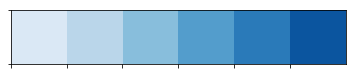

In [33]:
pal = sns.color_palette("Blues")
colours = pal.as_hex()
sns.palplot(sns.color_palette("Blues"))

> **Función que asocia una intensidad de color a cada valor de consumo para los 56 puntos en los 12 meses del 2013**

In [34]:
numero_intervalos = 6
rango = value_max - value_min
tamano_intervalo = rango / 6

def color_coding(row):
    if row['value'] >= value_min and row['value'] < (value_min + tamano_intervalo * 1):
        return colours[0]

    elif row['value'] >= (value_min + tamano_intervalo * 1) and row['value'] < (value_min + tamano_intervalo * 2):
        return colours[1]

    elif row['value'] >= (value_min + tamano_intervalo * 2) and row['value'] < (value_min + tamano_intervalo * 3):
        return colours[2]

    elif row['value'] >= (value_min + tamano_intervalo * 3) and row['value'] < (value_min + tamano_intervalo * 4):
        return colours[3]

    elif row['value'] >= (value_min + tamano_intervalo * 4) and row['value'] < (value_min + tamano_intervalo * 5):
        return colours[4]
    
    elif row['value'] >= (value_min + tamano_intervalo * 5) and row['value'] <= (value_min + tamano_intervalo * 6):
        return colours[5]
    
city_month_electricity['color'] = city_month_electricity.apply(lambda row: color_coding(row), axis=1)
city_month_electricity['latitude'] = city_month_electricity['city'].apply(lambda x: coordinates[x][0])
city_month_electricity['longitude'] = city_month_electricity['city'].apply(lambda x: coordinates[x][1])
city_month_electricity['step'] = city_month_electricity['month'].apply(lambda x: str(x)+"/2013" if x>9 
                                                                       else '0'+str(x)+"/2013")
city_month_electricity['step'] = pd.to_datetime(city_month_electricity['step'], format="%m/%Y")

In [35]:
city_month_electricity.head()

,city,month,value,temperatureMax,temperatureMin,color,latitude,longitude,step
0,Alpena,1,989.111970,13.44,-19.12,#bad6eb,45.083333,-83.55,2013-01-01
1,Alpena,2,869.350745,4.46,-18.15,#bad6eb,45.083333,-83.55,2013-02-01
2,Alpena,3,851.987202,9.38,-15.37,#bad6eb,45.083333,-83.55,2013-03-01
3,Alpena,4,750.208848,19.91,-7.31,#dbe9f6,45.083333,-83.55,2013-04-01
4,Alpena,5,692.130326,26.44,-1.18,#dbe9f6,45.083333,-83.55,2013-05-01


Observamos a continuación el número de colores distintos para cada punto de medida. Un número alto significa una gran variación en el consumo mensual de ese punto.

In [36]:
diff_colours_by_city = city_month_electricity.groupby(['city', 'color']).size().reset_index(name='Diff Colours')
print("Número de colores distintospara los 12 meses:\n", dict(diff_colours_by_city.city.value_counts()))

Número de colores distintospara los 12 meses:
 {'Jackson': 5, 'SanAntonio': 4, 'Mobile': 4, 'Savannah': 4, 'Kotzebue': 3, 'Tucumcari': 3, 'NewOrleans': 3, 'Miami': 3, 'OklahomaCity': 3, 'FortSmith': 3, 'Wichita': 3, 'Norfolk': 3, 'Fairbanks': 3, 'Athens': 2, 'Columbus': 2, 'Pocatello': 2, 'Indianapolis': 2, 'InternationalFalls': 2, 'GrandJunction': 2, 'Boston-Logan': 2, 'LaCrosse': 2, 'GreatFalls': 2, 'Charleston': 2, 'CedarCity': 2, 'Sheridan': 2, 'AtlanticCity': 2, 'DesMoines': 2, 'Bridgeport': 2, 'Glasgow': 2, 'RapidCity': 2, 'Springfield': 2, 'Bismarck': 2, 'Baltimore': 2, 'Greenville-Spartanburg': 2, 'Alpena': 2, 'Lansing': 2, 'CapeHatteras': 2, 'Williamsport': 2, 'Providence': 2, 'Burlington': 2, 'Lexington': 2, 'NewYorkCity-CentralPark': 2, 'Reno': 2, 'Flint': 2, 'Flagstaff': 2, 'StLouis': 2, 'Honolulu': 2, 'TraverseCity': 2, 'Caribou': 2, 'Wilmington': 2, 'Olympia': 2, 'Bristol': 2, 'Concord': 2, 'SanFrancisco': 1, 'Astoria': 1, 'LosAngeles': 1}


### Generación del fichero GeoJson
---

In [37]:
def generar_GeoJson(data):
    features = []
    for _, row in data.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['longitude'],row['latitude']]
            },
            'properties': {
                'time': row['step'].__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillOpacity': 0.5,
                    'radius': 20
                }
            }
        }
        features.append(feature)
    return features

Por último, vamos a generar el mapa agregando el plugin `TimestampedGeoJson` de folium. Esto agrega al mapa un control de tiempo, en la parte inferior derecha, que permite visualizar la información de forma dinámica

In [38]:
mapa = folium.Map(location=USA_coordinates, tiles='OpenStreetMap', zoom_start=3)

def generar_mapa(features):
    TimestampedGeoJson(
        {'type': 'FeatureCollection',
         'features': features},
        period='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False, 
        max_speed=1,
        loop_button=True, 
        date_options='MM/YYYY',
        time_slider_drag_update=True
    ).add_to(mapa)
    return mapa

plot_data = generar_GeoJson(city_month_electricity)
w = generar_mapa(plot_data)
for c in city_month_electricity.city.unique().tolist():
    folium.Marker(location=coordinates[c], 
                  tooltip=c).add_to(w)
w

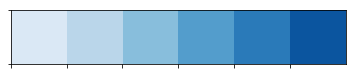

In [39]:
sns.palplot(sns.color_palette("Blues"))